# Development of an Embedded System for Detecting Acoustic Alert Signals of Cyclists Using Neural Networks

Author: Clemens Kubach

## Runtime Setup

Necessary for each execution of the notebook.

There are 3 options, how you could run the notebook:
- use Google Cloud Storage Bucket as data source with direct user login (admin - you should be the owner of the gcs bucket or a user with corresponding permissons)
- use Google Cloud Storage Bucket as data source with service account credentials from json key file
- use the locally extracted folder of the bucket zip file as data source

The first two options are extensively tested on Google Colab. For the third option, the questioned folder paths should be passed correctly, tested on linux.

In [ ]:
USE_GCS = True
if USE_GCS:
  AS_ADMIN = False

Be sure to have an instance running within NA for lower costs of network traffic from google cloud storage. If your VM isn't in NA or EU, you can reinitialize your colab instance.

In [ ]:
if USE_GCS:
  d = !curl ipinfo.io
  inEURegion = False
  inNARegion = False
  for e in d:
    print(e)
    if "NL" in e or 'BEL' in e:
      inEURegion = True
    elif "US" in e:
      inNARegion = True
  if not inNARegion and not inEURegion:
    raise EnvironmentError('VM has to be in (NA/EU) for lower costs')

{
  "ip": "35.231.216.161",
  "hostname": "161.216.231.35.bc.googleusercontent.com",
  "city": "North Charleston",
  "region": "South Carolina",
  "country": "US",
  "loc": "32.8546,-79.9748",
  "org": "AS15169 Google LLC",
  "postal": "29415",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}


Tested with Python 3.7.13!

In [ ]:
!python --version

Python 3.7.13


Install all dependencies with pip. The neural network models are installed from the [corresponding github repo](https://github.com/ClemensKubach/bicycle-bell-sed-models). 

If this repository is private, you need granted permissons by [Clemens Kubach](https://github.com/ClemensKubach). Create a github personal access token for accessing your repositories and insert it in the following dialog.

In [ ]:
REPO_IS_PUBLIC = True
if REPO_IS_PUBLIC:
  github_link = 'https://github.com/ClemensKubach/bicycle-bell-sed-models.git'
else:
  from IPython.display import clear_output
  gh_token = input('Github token:')
  clear_output()
  github_link = f'https://{gh_token}@github.com/ClemensKubach/bicycle-bell-sed-models.git'
!pip install git+$github_link
!pip install tensorflow-addons tensorflow-datasets
!pip install fsspec gcsfs
!pip install audiomentations==0.24.0
#!pip install -U tensorflow-probability==0.15.0
!pip install -U tensorflow_io==0.23.1
!pip install tqdm pandas matplotlib
!pip install google-colab google-cloud

  Cloning https://****@github.com/ClemensKubach/bicycle-bell-sed-models.git to /tmp/pip-req-build-jx6z0m91
  Running command git clone -q 'https://****@github.com/ClemensKubach/bicycle-bell-sed-models.git' /tmp/pip-req-build-jx6z0m91
     |████████████████████████████████| 23.4 MB 93.2 MB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 
  Created wheel for bicycle-bell-sed-models: filename=bicycle_bell_sed_models-0.0.1-py3-none-any.whl size=14718 sha256=2d9f0eb6b9fdc6d3cf7fdac5f89ef5d95cff0b95b61b7fc6a2bfd598af4567f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7s4omug6/wheels/32/e6/50/bd71e16a911a6595780cff88628910489818d08909fdf91772
Successfully built bicycle-bell-sed-models
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 136 kB 5.1 MB/s 
     |████████████████████████████████| 134 kB 42.4 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |██

Import all libraries. Tested with Tensorflow 2.8.0!

In [ ]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
import tensorflow_addons as tfa
import tensorflow_io as tfio
import tensorflow_datasets as tfds # check pip

from audiomentations import Compose, AddGaussianSNR, TimeStretch, PitchShift, AddBackgroundNoise, TimeMask, FrequencyMask
import pandas as pd

import multiprocessing
from pathlib import Path
import os
import json
import csv

from tqdm.notebook import tqdm
from IPython.display import Audio
import matplotlib.pyplot as plt

# models of the bicycle_bell_sed_models repository
from bicycle_bell_sed_models.models.crnn import crnn 
from bicycle_bell_sed_models.models.yamnet_base import yamnet_base
from bicycle_bell_sed_models.models.yamnet_lstm_fc import yamnet_lstm_fc

# Google Cloud usage
from google.colab import auth
from google.cloud import storage

TensorFlow version: 2.8.0


Authenticate to the Google Cloud Storage Bucket or insert path to the local bucket folder in case of `USE_GCS==False`.
The folder should be extracted from the bucket zip file. In the following dialog, the path of the top level folder is asked, like `/content/thesis-bicycle-bell-sed-bucket`.

In [ ]:
# Authenticate to GCS.
if USE_GCS:
  if AS_ADMIN:
    print('Insert the path to the uploaded Google Cloud credentials json with read and write permissions:')
    auth.authenticate_service_account()
    #auth.authenticate_user() # better to create a service account with key
  else:
    print('Insert the path to the uploaded Google Cloud credentials json:')
    auth.authenticate_service_account()

  GCS_PROJECT_ID = 'bachelor-thesis-bicyclebell'

  if inEURegion:
    GCS_BUCKET_NAME = 'thesis-bicycle-bell-sed-bucket-eu'
  elif inNARegion:
    GCS_BUCKET_NAME = 'thesis-bicycle-bell-sed-bucket-na'

  !gcloud config set project $GCS_PROJECT_ID
  os.environ['GOOGLE_CLOUD_PROJECT'] = GCS_PROJECT_ID
  !gcloud auth activate-service-account --key-file $GOOGLE_APPLICATION_CREDENTIALS
else:
  localPathToExtractedBucketZip = input('Insert the path to the extracted bucket zip folder:')

Insert the path to the uploaded Google Cloud credentials json:
Successfully saved credentials for colab-user@bachelor-thesis-bicyclebell.iam.gserviceaccount.com
Updated property [core/project].
Activated service account credentials for: [colab-user@bachelor-thesis-bicyclebell.iam.gserviceaccount.com]


Create all corresponding paths as constants automatically with the expected structure. This structure is given in GCS, as well as in the bucket-copy within the zip file. No changes necessary here.

In [ ]:
if USE_GCS:
  BASEPATH = f'gs://{GCS_BUCKET_NAME}'
else:
  BASEPATH = localPathToExtractedBucketZip

CSV_BASEPATH = os.path.join(BASEPATH, 'csv-datasets')
WAVE_BASEPATH = os.path.join(BASEPATH, 'wave-files')
TFRECORDS_BASEPATH = os.path.join(BASEPATH, 'tfrecords')
MODELS_BASEPATH = os.path.join(BASEPATH, 'models')
SYSTEMTEST_BASEPATH = os.path.join(BASEPATH, 'system-tests')

WAVE_ORIGINALS_BASEPATH = os.path.join(WAVE_BASEPATH, 'originals')
TFRECORDS_ORIGINALS_BASEPATH = os.path.join(TFRECORDS_BASEPATH, 'originals')

CSV_FSD50K_GT_PATH = os.path.join(CSV_BASEPATH, 'FSD50K.ground_truth')
WAVE_ORIGINALS_FSD50K_DEV_PATH = os.path.join(WAVE_ORIGINALS_BASEPATH, 'FSD50K.dev_audio')
WAVE_ORIGINALS_FSD50K_EVAL_PATH = os.path.join(WAVE_ORIGINALS_BASEPATH, 'FSD50K.eval_audio')
TFRECORDS_ORIGINALS_FSD50K_DEV_TRAIN_PATH = os.path.join(TFRECORDS_ORIGINALS_BASEPATH, 'FSD50K.dev_train_audio')
TFRECORDS_ORIGINALS_FSD50K_DEV_VAL_PATH = os.path.join(TFRECORDS_ORIGINALS_BASEPATH, 'FSD50K.dev_val_audio')
TFRECORDS_ORIGINALS_FSD50K_EVAL_PATH = os.path.join(TFRECORDS_ORIGINALS_BASEPATH, 'FSD50K.eval_audio')

CSV_FSD50K_DEV_PATH = os.path.join(CSV_FSD50K_GT_PATH, 'dev.csv')
CSV_FSD50K_EVAL_PATH = os.path.join(CSV_FSD50K_GT_PATH, 'eval.csv')
CSV_FSD50K_VOCABULARY_PATH = os.path.join(CSV_FSD50K_GT_PATH, 'vocabulary.csv')

## Prepare Raw Wave and CSV Files in GCS

Necessary just for the first run of the notebook, if only the raw FSD50K dataset files are downloaded.

The GCS bucket has to be prepared with the following subfolders:

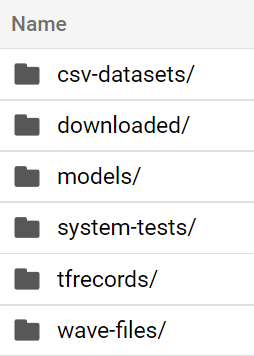

The in-depth folder structure can be derived from the above path-constants.

The [FSD50K Dataset](https://annotator.freesound.org/fsd/release/FSD50K/) with all its individual files have to be downloaded manually and placed into the folder `downloaded/` of the bucket.
Then, they are merged together and are uploaded sample-wise into the folder `wave-files/orginals/`.

In [ ]:
def download_filesFolders_fromGCS(folderToDownload='FSD50K/', localDirTarget='content/'):
  """
    Download the whole folder `folderToDownload` with all including files into the specified local Colab folder `localDirTarget`.

    :param str folderToDownload: Path of folder of interest in GCS
  """
  prefix = folderToDownload # dir which is to download with all its files and nested dirs
  dl_dir = localDirTarget

  storage_client = storage.Client(GCS_PROJECT_ID)
  bucket = storage_client.get_bucket(GCS_BUCKET_NAME)
  blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
  for blob in blobs:
      if blob.name.endswith("/"):
          continue
      file_split = blob.name.split("/")
      directory = "/".join(file_split[0:-1])
      Path(directory).mkdir(parents=True, exist_ok=True)
      blob.download_to_filename(blob.name) 
  print('Download complete')

def upload_file_toGCS(fileToUpload, targetBlob, parallel_threshold='100M'):
  """
    Upload the file `fileToUpload` into the specified folder `targetLocation` in GCS.
    
    :param str parallel_threshold: Estimated file size for a faster upload
  """
  fileToUpload_path = f'/content/{fileToUpload}'
  targetLocation = f'gs://{GCS_BUCKET_NAME}/{targetBlob}/{fileToUpload}'

  !gsutil -m -o GSUtil:parallel_composite_upload_threshold=$parallel_threshold cp -r $fileToUpload_path $targetLocation
  print('Upload complete')

Download raw zips, merge, unzip and upload individual files to GCS. Alternatively, the Dataset could be downloaded from the original [FSD50K Website](https://annotator.freesound.org/fsd/release/FSD50K/).

In [ ]:
if USE_GCS and AS_ADMIN:
  # load all downloaded data for gcs
  download_filesFolders_fromGCS(folderToDownload='downloaded/', localDirTarget='/content')
else:
  print('Downloaded FSD50K zips are already in the local bucket zip!')

Download complete


In [ ]:
def downloadedZipsToGCS(baseZipFilename, targetBlob):
  _mergedZipInput = os.path.join('downloaded', baseZipFilename)
  _mergedZipOutput = os.path.join(f'merged.{baseZipFilename}')
  _nameWithoutZip = baseZipFilename.split('.zip')[0]

  # merge zip files
  !zip -s 0 $_mergedZipInput --out $_mergedZipOutput
  # seperate wavs
  !unzip $_mergedZipOutput
  # upload folder with unziped and seperated wavs
  upload_file_toGCS(_nameWithoutZip, targetBlob, parallel_threshold='100M')
  # clean up
  !rm -rf $_mergedZipOutput
  !rm -rf $_nameWithoutZip

In [ ]:
if USE_GCS and AS_ADMIN:
  # dev data
  downloadedZipsToGCS('FSD50K.dev_audio.zip', 'wave-files/originals')

  # eval data
  downloadedZipsToGCS('FSD50K.eval_audio.zip', 'wave-files/originals')

  # ground truth data
  downloadedZipsToGCS('FSD50K.ground_truth.zip', 'csv-datasets')
else:
  print('Individual FSD50K wave files are already in the local bucket zip!')

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Copying file:///content/FSD50K.eval_audio/255716.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/71139.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/209524.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/83521.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/315648.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/268538.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/350619.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/325132.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/382735.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/434155.wav [Content-Type=audio/x-wav]...
Copying file:///content/FSD50K.eval_audio/399198.wav [Content-Type=audio/x-wav]...
Copying file:///conten

## Read and Inspect Dataset

Necessary if changing tfrecord dataset format or content.

Inspect csv

In [ ]:
df_fsd50k_dev = pd.read_csv(CSV_FSD50K_DEV_PATH)

In [ ]:
df_fsd50k_dev.head()

,fname,labels,mids,split
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train


Inspect wave with a sampling rate of 44100 Hz and with 16000 Hz.

44100 to 44100


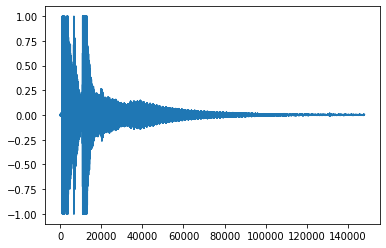

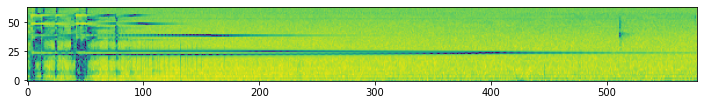

In [ ]:
targetSr = 44100
audio = tfio.audio.AudioIOTensor(f'{WAVE_ORIGINALS_FSD50K_DEV_PATH}/9218.wav') # (samples, channels)
sr = audio.rate.numpy()
print(sr, 'to', targetSr)
audio_slice = audio.to_tensor()
audio_tensor = tf.squeeze(audio_slice, axis=[-1]) # remove last dimension
audio_tensor_resampled = tfio.audio.resample(audio_tensor, sr, targetSr)
display(Audio(audio_tensor_resampled.numpy(), rate=targetSr))


tensorWave = tf.cast(audio_tensor_resampled, tf.float32) / 32768.0
plt.figure()
plt.plot(tensorWave.numpy())

spectrogram = tfio.audio.spectrogram(tensorWave, nfft=512, window=512, stride=256)
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=targetSr, mels=64, fmin=125, fmax=targetSr//2)
# Convert to db scale mel-spectrogram
dbscale_log_mel_spectrogram = tfio.audio.dbscale(
    tf.math.log(mel_spectrogram+0.001), top_db=40)
plt.figure(figsize=(12, 9))
plt.imshow(dbscale_log_mel_spectrogram.numpy().T, origin='lower')

44100 to 16000
tf.Tensor([-145 -107  -52 ...  123  143  134], shape=(147968,), dtype=int16)


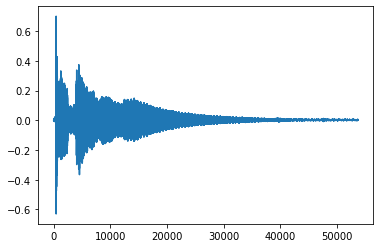

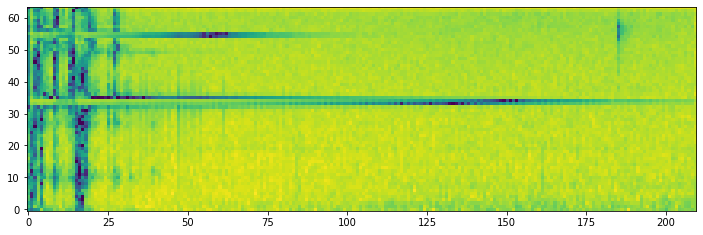

In [ ]:
targetSr = 16000
audio = tfio.audio.AudioIOTensor(f'{WAVE_ORIGINALS_FSD50K_DEV_PATH}/9218.wav') # (samples, channels)
sr = audio.rate.numpy()
print(sr, 'to', targetSr)
audio_slice = audio.to_tensor()
audio_tensor = tf.squeeze(audio_slice, axis=[-1]) # remove last dimension
print(audio_tensor)
audio_tensor_resampled = tfio.audio.resample(audio_tensor, sr, targetSr)
display(Audio(audio_tensor_resampled.numpy(), rate=targetSr))


tensorWave = tf.cast(audio_tensor_resampled, tf.float32) / 32768.0
plt.figure()
plt.plot(tensorWave.numpy())

spectrogram = tfio.audio.spectrogram(tensorWave, nfft=512, window=512, stride=256)
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=targetSr, mels=64, fmin=125, fmax=targetSr//2)
# Convert to db scale mel-spectrogram
dbscale_log_mel_spectrogram = tfio.audio.dbscale(
    tf.math.log(mel_spectrogram+0.001), top_db=40)
plt.figure(figsize=(12, 9))
plt.imshow(dbscale_log_mel_spectrogram.numpy().T, origin='lower')

Read Ontology of [AudioSet](https://research.google.com/audioset/ontology/index.html) which is used in FSD50K.

In [ ]:
class Ontology(object):
  
  def __init__(self, pathToRepoJson: str='/content/ontology/ontology.json' , gAudioSetRepository: str='https://github.com/audioset/ontology.git', fsd50kVocabulary: str=CSV_FSD50K_VOCABULARY_PATH) -> None:
    super().__init__()
    try:
      !git clone $gAudioSetRepository
    except:
      print('Skipping downloading: ontology repository already exists')

    with open(pathToRepoJson, mode='r') as f:
      ontology_file = json.loads(f.read())

    self.ontology_id_content_map = {}
    self.ontology_name_id_map = {}

    for element in ontology_file:
      self.ontology_id_content_map[element['id']] = element
      self.ontology_name_id_map[element['name']] = element['id']

    self.ontology_id_label_map = {}
    vocab_df = pd.read_csv(fsd50kVocabulary, header=None)
    for index, row in vocab_df.iterrows():
      self.ontology_id_label_map[row[2]] = row[1]

  def getLabel_fromName(self, name: str):
    """
    Returns the FSD50K label name of the received Google AudioSet Ontology `name`.
    """
    return self.ontology_id_label_map[self.ontology_name_id_map[name]]

In [ ]:
ONTOLOGY = Ontology(pathToJsonFromRepo='/content/ontology/ontology.json', gAudioSetRepository='https://github.com/audioset/ontology.git')

ONTOLOGY.getLabel_fromName('Traffic noise, roadway noise')

Cloning into 'ontology'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


'Traffic_noise_and_roadway_noise'

Set constants

In [ ]:
EXAMPLE_ID = 1
EVENT_LABEL = ONTOLOGY.getLabel_fromName('Bicycle bell')
print(EVENT_LABEL)

Read csv files.

In [ ]:
df_fsd50k_dev = pd.read_csv(CSV_FSD50K_DEV_PATH)
df_fsd50k_eval = pd.read_csv(CSV_FSD50K_EVAL_PATH)

Add a column with the information, if the wave contains the ringing of a bicycle bell.

In [ ]:
def isBicycleBell_inRow(row):
  return EVENT_LABEL in row['labels'].split(',')

df_fsd50k_dev['isBicycleBell'] = df_fsd50k_dev.apply(lambda row: isBicycleBell_inRow(row), axis=1)
df_fsd50k_eval['isBicycleBell'] = df_fsd50k_eval.apply(lambda row: isBicycleBell_inRow(row), axis=1)

print('Dev:')
display(df_fsd50k_dev.head())
print('\nEval:')
display(df_fsd50k_eval.head())

print('\nShow Sample 9218:')
display(df_fsd50k_dev[df_fsd50k_dev['fname']==9218])

Dev:


,fname,labels,mids,split,isBicycleBell
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False



Eval:


,fname,labels,mids,isBicycleBell
0,37199,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False
1,175151,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False
2,253463,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False
3,329838,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False
4,1277,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False



Show Sample 9218:


,fname,labels,mids,split,isBicycleBell
8616,9218,"Bicycle_bell,Bell,Alarm,Bicycle,Vehicle","/m/0gy1t2s,/m/0395lw,/m/07pp_mv,/m/0199g,/m/07yv9",val,True


Add a column with the information if the wave should be in the relevant subset of the FSD50K dataset.
Only files with at least one of the following labels are respected:
- Bicycle Bell
- Traffic noise, roadway noise
- Car
- Truck
- Bus
- Siren
- Wind
- Rain
- Human voice

In [ ]:
def label_inRow(row, selectedLabels):
  row_labels = row['labels'].split(',')
  for label in selectedLabels:
    if label in row_labels:
      return True
  return False

selectedLabels = [EVENT_LABEL, 
                ONTOLOGY.getLabel_fromName('Traffic noise, roadway noise'),
                ONTOLOGY.getLabel_fromName('Car'),
                ONTOLOGY.getLabel_fromName('Truck'),
                ONTOLOGY.getLabel_fromName('Bus'),
                ONTOLOGY.getLabel_fromName('Siren'),
                ONTOLOGY.getLabel_fromName('Wind'),
                ONTOLOGY.getLabel_fromName('Rain'),
                ONTOLOGY.getLabel_fromName('Human voice'),] 

df_fsd50k_dev['inSubset'] = df_fsd50k_dev.apply(lambda row: label_inRow(row, selectedLabels), axis=1)
df_fsd50k_eval['inSubset'] = df_fsd50k_eval.apply(lambda row: label_inRow(row, selectedLabels), axis=1)

print('Dev:')
display(df_fsd50k_dev.head())
print('\nEval:')
display(df_fsd50k_eval.head())

Dev:


,fname,labels,mids,split,isBicycleBell,inSubset
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False



Eval:


,fname,labels,mids,isBicycleBell,inSubset
0,37199,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False
1,175151,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False
2,253463,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False
3,329838,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False
4,1277,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False


In [ ]:
print('Dev:')
display(df_fsd50k_dev[df_fsd50k_dev['inSubset']].head())
print('\nEval:')
display(df_fsd50k_eval[df_fsd50k_eval['inSubset']].head())

Dev:


,fname,labels,mids,split,isBicycleBell,inSubset
721,216565,"Coin_(dropping),Conversation,Domestic_sounds_a...","/m/0242l,/m/01h8n0,/t/dd00071,/m/09x0r,/m/09l8g",train,False,True
881,233286,"Coin_(dropping),Singing,Domestic_sounds_and_ho...","/m/0242l,/m/015lz1,/t/dd00071,/m/09l8g",train,False,True
937,87315,"Coin_(dropping),Walk_and_footsteps,Zipper_(clo...","/m/0242l,/m/07pbtc8,/m/01s0vc,/m/01h8n0,/m/01b...",val,False,True
943,403457,"Vehicle_horn_and_car_horn_and_honking,Car,Moto...","/m/0912c9,/m/0k4j,/m/012f08,/m/07yv9,/m/07pp_mv",train,False,True
944,402958,"Vehicle_horn_and_car_horn_and_honking,Car,Moto...","/m/0912c9,/m/0k4j,/m/012f08,/m/07yv9,/m/07pp_mv",train,False,True



Eval:


,fname,labels,mids,isBicycleBell,inSubset
63,240186,"Electric_guitar,Applause,Crowd,Cheering,Clappi...","/m/02sgy,/m/028ght,/m/03qtwd,/m/053hz1,/m/0l15...",False,True
128,390297,"Electric_guitar,Male_singing,Cymbal,Drum_kit,F...","/m/02sgy,/t/dd00003,/m/01qbl,/m/02hnl,/m/0g6b5...",False,True
198,417430,"Coin_(dropping),Chuckle_and_chortle,Domestic_s...","/m/0242l,/m/07rgt08,/t/dd00071,/m/01j3sz,/m/09l8g",False,True
199,101807,"Coin_(dropping),Chatter,Male_singing,Conversat...","/m/0242l,/m/07rkbfh,/t/dd00003,/m/01h8n0,/t/dd...",False,True
202,232557,"Coin_(dropping),Human_voice,Domestic_sounds_an...","/m/0242l,/m/09l8g,/t/dd00071",False,True


In [ ]:
print('All files in Dev with Bicycle Bell:')
df_fsd50k_dev[df_fsd50k_dev['isBicycleBell']].head()

All files in Dev with Bicycle Bell:


,fname,labels,mids,split,isBicycleBell,inSubset
8616,9218,"Bicycle_bell,Bell,Alarm,Bicycle,Vehicle","/m/0gy1t2s,/m/0395lw,/m/07pp_mv,/m/0199g,/m/07yv9",val,True,True
8670,383595,"Bicycle_bell,Bell,Alarm,Bicycle,Vehicle","/m/0gy1t2s,/m/0395lw,/m/07pp_mv,/m/0199g,/m/07yv9",val,True,True
8677,78970,"Bicycle_bell,Bell,Alarm,Bicycle,Vehicle","/m/0gy1t2s,/m/0395lw,/m/07pp_mv,/m/0199g,/m/07yv9",train,True,True
8680,434818,"Bicycle_bell,Bell,Bicycle,Vehicle,Alarm","/m/0gy1t2s,/m/0395lw,/m/0199g,/m/07yv9,/m/07pp_mv",val,True,True
8683,78984,"Bicycle_bell,Bell,Alarm,Bicycle,Vehicle","/m/0gy1t2s,/m/0395lw,/m/07pp_mv,/m/0199g,/m/07yv9",train,True,True


In [ ]:
def filepath_inRow(row, wave_dataset_path):
  return os.path.join(wave_dataset_path, str(row['fname'])+'.wav')

filepath_root_dev = WAVE_ORIGINALS_FSD50K_DEV_PATH
filepath_root_eval = WAVE_ORIGINALS_FSD50K_EVAL_PATH

df_fsd50k_dev['fpath'] = df_fsd50k_dev.apply(lambda row: filepath_inRow(row, filepath_root_dev), axis=1)
df_fsd50k_eval['fpath'] = df_fsd50k_eval.apply(lambda row: filepath_inRow(row, filepath_root_eval), axis=1)

print('Dev:')
display(df_fsd50k_dev.head())
print('\nEval:')
display(df_fsd50k_eval.head())

Dev:


,fname,labels,mids,split,isBicycleBell,inSubset,fpath
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",train,False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...



Eval:


,fname,labels,mids,isBicycleBell,inSubset,fpath
0,37199,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
1,175151,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
2,253463,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
3,329838,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...
4,1277,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",False,False,gs://thesis-bicycle-bell-sed-bucket/wave-files...


Select rows with `inSubset==True` and seperate the dev set into train and val. The printed information about positives (`isBicycleBell==True`) are used for loading tfrecords later again.

In [ ]:
df_fsd50k_dev_train = df_fsd50k_dev.loc[(df_fsd50k_dev['split'] == 'train') & (df_fsd50k_dev['inSubset'])].drop(['labels', 'mids', 'split', 'inSubset'], axis=1)
df_fsd50k_dev_val = df_fsd50k_dev.loc[(df_fsd50k_dev['split'] == 'val') & (df_fsd50k_dev['inSubset'])].drop(['labels', 'mids', 'split', 'inSubset'], axis=1)
df_fsd50k_eval = df_fsd50k_eval.loc[(df_fsd50k_eval['inSubset'])].drop(['labels', 'mids', 'inSubset'], axis=1)

In [ ]:
print('Dev train:')
display(df_fsd50k_dev_train.info())
print('Number of Postives:', len(df_fsd50k_dev_train[df_fsd50k_dev_train['isBicycleBell']].index))
print('\nDev val:')
display(df_fsd50k_dev_val.info())
print('Number of Postives:', len(df_fsd50k_dev_val[df_fsd50k_dev_val['isBicycleBell']].index))
print('\nEval:')
display(df_fsd50k_eval.info())
print('Number of Postives:', len(df_fsd50k_eval[df_fsd50k_eval['isBicycleBell']].index))

Dev train:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5374 entries, 721 to 38254
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fname          5374 non-null   int64 
 1   isBicycleBell  5374 non-null   bool  
 2   fpath          5374 non-null   object
dtypes: bool(1), int64(1), object(1)
memory usage: 131.2+ KB


None

Number of Postives: 59

Dev val:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 937 to 38255
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fname          615 non-null    int64 
 1   isBicycleBell  615 non-null    bool  
 2   fpath          615 non-null    object
dtypes: bool(1), int64(1), object(1)
memory usage: 15.0+ KB


None

Number of Postives: 14

Eval:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 63 to 9771
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fname          2416 non-null   int64 
 1   isBicycleBell  2416 non-null   bool  
 2   fpath          2416 non-null   object
dtypes: bool(1), int64(1), object(1)
memory usage: 59.0+ KB


None

Number of Postives: 56


In [ ]:
df_fsd50k_dev_train[['fname', 'fpath']].values

array([[216565,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/216565.wav'],
       [233286,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/233286.wav'],
       [403457,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/403457.wav'],
       ...,
       [100850,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/100850.wav'],
       [100856,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/100856.wav'],
       [100857,
        'gs://thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/100857.wav']],
      dtype=object)

## Create TF Dataset and TFRecords in Bucket

Necessary if changing tfrecord dataset format or content.

Create TF Dataset for the pandas Dataframe. The wave data will be loaded for writing directly into the TFRecords. 

In [ ]:
from tensorflow.python.types.core import Tensor
target = ('isBicycleBell', tf.bool)
features = [('fname', tf.int32), ('fpath', tf.string),]

def createDataset_fromDataframe(df):
  ds = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df[features[0][0]].values, features[0][1], name=features[0][0]),
            tf.cast(df[features[1][0]].values, features[1][1], name=features[1][0]),
            tf.cast(df[target[0]].values, target[1], name=target[0])
        )
    )
  return ds

tf_ds_dev_train = createDataset_fromDataframe(df_fsd50k_dev_train)

tf_ds_dev_val = createDataset_fromDataframe(df_fsd50k_dev_val) 

tf_ds_eval = createDataset_fromDataframe(df_fsd50k_eval)

In [ ]:
f_decodeWav = lambda x_fpath: tf.audio.decode_wav(tf.io.read_file(x_fpath), desired_channels=1, desired_samples=-1)
f = lambda x_fname, x_fpath, y: (x_fname, tf.squeeze(f_decodeWav(x_fpath)[0], axis=[-1], name='audio'), f_decodeWav(x_fpath)[1], y)

tf_ds_dev_train_f = tf_ds_dev_train.map(f, num_parallel_calls=tf.data.AUTOTUNE)
tf_ds_dev_val_f = tf_ds_dev_val.map(f, num_parallel_calls=tf.data.AUTOTUNE)
tf_ds_eval_f = tf_ds_eval.map(f, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
bench_set = tf_ds_dev_train_f.interleave(lambda x_fname, x_audio, x_sr, y: tf.data.Dataset.from_tensors((x_fname, x_audio, x_sr, y)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).padded_batch(32, padded_shapes=((), (None,), (), ())).prefetch(buffer_size=tf.data.AUTOTUNE)
tfds.core.benchmark(bench_set, batch_size=32, num_iter=100)

0it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 113.52 ex/sec (total: 3296 ex, 29.03 sec)
Examples/sec (First only) 85.71 ex/sec (total: 32 ex, 0.37 sec)
Examples/sec (First excluded) 113.88 ex/sec (total: 3264 ex, 28.66 sec)


{'first+last': {'duration': 29.033980995998718,
  'num_examples': 3296,
  'avg': 113.52215186936418},
 'first': {'duration': 0.37334956799895735,
  'num_examples': 32,
  'avg': 85.71055852966559},
 'last': {'duration': 28.66063142799976,
  'num_examples': 3264,
  'avg': 113.88444138782172},
 'raw': {'start_time': 27175.983590051,
  'first_batch_time': 27176.356939619,
  'end_time': 27205.017571047,
  'num_iter': 103}}

Create TFRecords in GCS or the corresponding local paths.

In [ ]:
def createTFRecordFiles(dataset: tf.data.Dataset, target_folderpath: str, filename_base: str, examples_per_file: int=1024):
  """ 
    Creates TFRecord file with 3 features: fname (a single int), audio (a tensor of 1d floats), y (a single boolean/int).
    - `dataset` must be of finit length!
    - The `target_folderpath` could also be a GCS path. This not includes any filename.
    - `filename_base` is a part of each resulting tfrecord file. Typically it is the at the beginning of the filename followed by an id.
    - `examples_per_file` are the maximum number of examples/elements out of the dataset which will be in one tfrecord file. The number should be adjusted for a file size of 300M.
  """

  def tfrecordsNaming(filename_base, fileId) -> str:
    return f'{filename_base}_{fileId}.tfrecords'

  def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
      value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

  def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

  def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

  def to_tfrecord(fname, audio, sr, y):
    example = tf.train.Example(features = tf.train.Features(
                feature={
                    'fname': _int64_feature(fname),
                    'audio': _bytes_feature(tf.io.serialize_tensor(audio)),
                    'sr': _int64_feature(sr),
                    'y': _int64_feature(y),
                }
            )
        )
    return example

  dataset_size = tf.data.experimental.cardinality(dataset).numpy()
  elementCounter = 0
  passedDataElements = 0
  breakCalled = False
  fileId = 0
  for x_fname, x_audio, x_sr, y in tqdm(dataset.shuffle(dataset_size).prefetch(tf.data.AUTOTUNE)):
    if breakCalled:
      break
    passedDataElements += 1
    # if a new file begins
    if elementCounter == 0:
      current_filename = tfrecordsNaming(filename_base, fileId)
      filepath = os.path.join(target_folderpath, current_filename)
      writer = tf.io.TFRecordWriter(filepath)
      fileId += 1
    # Encode [fname, audio, y] pair to TFRecord format
    example = to_tfrecord(x_fname, x_audio, x_sr, y)
    # Write serialized example to TFRecord file
    writer.write(example.SerializeToString())

    elementCounter += 1
    # if file includes complete block
    if elementCounter == examples_per_file or passedDataElements == dataset_size:
      writer.close()
      elementCounter = 0
      if passedDataElements == dataset_size:
        breakCalled = True

In [ ]:
# dev train
createTFRecordFiles(tf_ds_dev_train_f, TFRECORDS_ORIGINALS_FSD50K_DEV_TRAIN_PATH, 'dev_train', examples_per_file=256)
# dev val
createTFRecordFiles(tf_ds_dev_val_f, TFRECORDS_ORIGINALS_FSD50K_DEV_VAL_PATH, 'dev_val', examples_per_file=256)
# eval
createTFRecordFiles(tf_ds_eval_f, TFRECORDS_ORIGINALS_FSD50K_EVAL_PATH, 'eval', examples_per_file=256)

  0%|          | 0/5374 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/2416 [00:00<?, ?it/s]

## Read TF Dataset from TFRecords

Needed for every model training or evaluation.

The TFRecord files are used for the training. These can either be loaded directly from GCS or your local bucket during the iteration process or can first be downloaded from GCS to the local storage of the VM. Which variant is to be used is specified with the variable `fromBucket`.

In [ ]:
def getDataset_fromTFRecords(source_folderpath: str, filename_base: str, fromBucket: bool=True, maxWaveSeconds: int=60):
  """ 
    Creates TFRecord file with 3 features: fname (a single int), audio (a tensor of 1d floats), y (a single boolean/int).
    - The `source_folderpath` could also be a GCS path. This not includes any filename.
    - `filename_base` is a part of each resulting tfrecord file. Typically it is the at the beginning of the filename followed by an id.
  """
  MULTI = 4 #32

  # filter gcs files for relevant tfrecords
  filter_filetype = '.tfrecords'
  filepaths = []
  if fromBucket:
    storage_client = storage.Client(GCS_PROJECT_ID)
    for blob in storage_client.list_blobs(GCS_BUCKET_NAME, prefix=source_folderpath.split(f'{GCS_BUCKET_NAME}/')[1]):
      filepaths.append(os.path.join(BASEPATH, blob.name))
  else:
    for f in os.listdir(source_folderpath):
      if os.path.isfile(os.path.join(source_folderpath, f)):
        filepaths.append(os.path.join(source_folderpath, f))
  filepaths.sort(key=lambda link: int(link[link.rindex('_')+1:link.index(filter_filetype)]) )

  feature_description = {
        'fname': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'audio': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'sr': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'y': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
  
  def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    example_unserialized = tf.io.parse_single_example(example_proto, feature_description)
    parsed_tensor = tf.io.parse_tensor(example_unserialized['audio'], tf.float32)
    if maxWaveSeconds is not None and maxWaveSeconds > 0:
      maxSamples = int(example_unserialized['sr'] * maxWaveSeconds)
      if maxSamples < tf.shape(parsed_tensor)[0]:
        example_unserialized['audio'] = parsed_tensor[:maxSamples]
      else:
        example_unserialized['audio'] = parsed_tensor
    else: 
      example_unserialized['audio'] = parsed_tensor
    return example_unserialized

  def readDataset_fromTfrecords(tfrecordFileList: list) -> tf.data.Dataset:
    raw_dataset = tf.data.TFRecordDataset(tfrecordFileList, num_parallel_reads=MULTI*multiprocessing.cpu_count())
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=MULTI*multiprocessing.cpu_count())
    return parsed_dataset

  parsed_dataset = readDataset_fromTfrecords(filepaths)
  return parsed_dataset

In [ ]:
fromBucket = True

if USE_GCS and not fromBucket:
  !mkdir tfrecords
  !gsutil -m cp -r $TFRECORDS_ORIGINALS_BASEPATH ./tfrecords

if not USE_GCS:
  fromBucket = True # uses path constants

# dev train
sourcePath = TFRECORDS_ORIGINALS_FSD50K_DEV_TRAIN_PATH if fromBucket else '/content/tfrecords/originals/FSD50K.dev_train_audio'
tfrecords_dev_train = getDataset_fromTFRecords(sourcePath, 'dev_train', fromBucket=fromBucket)
tfrecords_dev_train_size = 5374
tfrecords_dev_train_pos_size = 59
# dev val
sourcePath = TFRECORDS_ORIGINALS_FSD50K_DEV_VAL_PATH if fromBucket else '/content/tfrecords/originals/FSD50K.dev_val_audio'
tfrecords_dev_val = getDataset_fromTFRecords(sourcePath, 'dev_val', fromBucket=fromBucket)
tfrecords_dev_val_size = 615
tfrecords_dev_val_pos_size = 14
# eval
sourcePath = TFRECORDS_ORIGINALS_FSD50K_EVAL_PATH if fromBucket else '/content/tfrecords/originals/FSD50K.eval_audio'
tfrecords_eval = getDataset_fromTFRecords(sourcePath, 'eval', fromBucket=fromBucket)
tfrecords_eval_size = 2416
tfrecords_eval_pos_size = 56

### Data Benchmarks

Benchmarks of loading data from tfrecords.

In [ ]:
bench_set = tfrecords_dev_train.padded_batch(32, padded_shapes={'fname': (), 'audio': (None,), 'sr': (), 'y': ()}).prefetch(buffer_size=tf.data.AUTOTUNE)
tfds.core.benchmark(bench_set, batch_size=32, num_iter=400)

0it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 256.88 ex/sec (total: 12896 ex, 50.20 sec)
Examples/sec (First only) 138.15 ex/sec (total: 32 ex, 0.23 sec)
Examples/sec (First excluded) 257.43 ex/sec (total: 12864 ex, 49.97 sec)


{'first+last': {'duration': 50.202762581,
  'num_examples': 12896,
  'avg': 256.8782938825898},
 'first': {'duration': 0.23163578700007292,
  'num_examples': 32,
  'avg': 138.14791062483764},
 'last': {'duration': 49.97112679399993,
  'num_examples': 12864,
  'avg': 257.4286558121917},
 'raw': {'start_time': 547.609905413,
  'first_batch_time': 547.8415412,
  'end_time': 597.812667994,
  'num_iter': 403}}

In [ ]:
bench_set = tfrecords_dev_train.shuffle(1024, seed=42, reshuffle_each_iteration=True).padded_batch(32, padded_shapes={'fname': (), 'audio': (None,), 'sr': (), 'y': ()}).prefetch(tf.data.AUTOTUNE)
tfds.core.benchmark(bench_set, batch_size=32, num_iter=100)

0it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 331.23 ex/sec (total: 3296 ex, 9.95 sec)
Examples/sec (First only) 17.43 ex/sec (total: 32 ex, 1.84 sec)
Examples/sec (First excluded) 402.20 ex/sec (total: 3264 ex, 8.12 sec)


{'first+last': {'duration': 9.950775158000397,
  'num_examples': 3296,
  'avg': 331.2304767885369},
 'first': {'duration': 1.8354189450001286,
  'num_examples': 32,
  'avg': 17.43471161566209},
 'last': {'duration': 8.115356213000268,
  'num_examples': 3264,
  'avg': 402.2004597618631},
 'raw': {'start_time': 2428.479794261,
  'first_batch_time': 2430.315213206,
  'end_time': 2438.430569419,
  'num_iter': 103}}

### Data Preprocessing and Augmentation Classes

Contains settings for the data augmentation, later model creation and dataset preparation.

In [ ]:
#from tensorflow.python.ops.math_ops import xor_

class Subset(object):
  def __init__(self, subset, subset_size, num_positives) -> None:
    self.subset = subset
    self.size = subset_size
    self.num_positives = num_positives
    self.augmentationFactor = Subset._augmentationFactor(subset_size, num_positives)
  
  def _augmentationFactor(subset_size, num_positives):
    """ Calculate oversampling factor for a nearly balanced dataset. """
    return max(1, subset_size // num_positives)

  def from_Subset(class_instance):
    return Subset(class_instance.subset, class_instance.size, class_instance.num_positives)


class SplittedDatasets(object):
  def __init__(self, trainSubset: Subset, valSubset: Subset, evalSubset: Subset, useClassWeight=False) -> None:
    self.trainSubset: Subset = trainSubset
    self.valSubset: Subset = valSubset
    self.evalSubset: Subset = evalSubset
    self.notAugmentedErrors = 0
    self.cpuCount = multiprocessing.cpu_count()
    self.classWeight = SplittedDatasets.calculate_class_weights_directly(self.trainSubset.num_positives, 
                                                        self.trainSubset.size-self.trainSubset.num_positives, 
                                                        self.trainSubset.size)
    self.useClassWeight = useClassWeight


  def calculate_class_weights_directly(num_pos, num_neg, total):
    weight_neg = (1 / num_neg) * (total / 2.0)
    weight_pos = (1 / num_pos) * (total / 2.0)
    # print('Number of positive samples:', num_pos)
    # print('Number of negative samples:', num_neg)
    return {0: weight_neg, 1: weight_pos}

  def prepare(self, sample_rate, batch_size, epochs=1, learningRate=0.001, shuffleBuffer=4096):
    self.sample_rate = sample_rate
    self.batch_size = batch_size
    self.epochs = epochs
    self.shuffleBuffer = shuffleBuffer
    self.learning_rate = learningRate
    
    def prepareSubset(subset: Subset, balance=True, isEval=False) -> Subset:
      preparationSubset = Subset.from_Subset(subset)
      self.resampleRename(preparationSubset)
      if balance:
        self.augmentate(preparationSubset)
      self.shuffle(preparationSubset)
      if not isEval:
        self.repeat(preparationSubset)
      if self.useClassWeight:
        self.modelFormatting(preparationSubset)
      self.batch(preparationSubset)
      self.prefetch(preparationSubset)
      return preparationSubset
    
    # prepare balanced datasets
    self.prepared_balanced_trainSubset = prepareSubset(self.trainSubset)
    self.prepared_balanced_valSubset = prepareSubset(self.valSubset)
    self.prepared_balanced_evalSubset = prepareSubset(self.evalSubset, isEval=True)

    # prepare imbalanced datasets
    self.prepared_imbalanced_trainSubset = prepareSubset(self.trainSubset, balance=False)
    self.prepared_imbalanced_valSubset = prepareSubset(self.valSubset, balance=False)
    self.prepared_imbalanced_evalSubset = prepareSubset(self.evalSubset, balance=False, isEval=True)

    return self.prepared_balanced_trainSubset, self.prepared_balanced_valSubset, self.prepared_balanced_evalSubset

  def resampleRename(self, preparationSubset: Subset):
    _resampleFunction = lambda ex: (
      {
          f'fname': ex['fname'],
          f'wav_{self.sample_rate}_mono_input': tfio.audio.resample(ex['audio'], ex['sr'], self.sample_rate)
      }, 
      {
          'class_output': ex['y']
      }
    )
    preparationSubset.subset = preparationSubset.subset.map(_resampleFunction, num_parallel_calls=4*multiprocessing.cpu_count())

  def augmentate(self, preparationSubset: Subset):

    def _augmentationPipe(p, background_soundsDir: str='/content/backgroundSounds') -> Compose:
      ai_AddGaussianNoiseSNR = AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=40.0, p=0.8) # no retiming
      #ai_AddBackgroundNoise = AddBackgroundNoise(sounds_path=background_soundsDir, min_absolute_rms_in_db=-45,
      #                          max_absolute_rms_in_db=-20, noise_rms='absolute', lru_cache_size=10, p=0.9) # no retiming
      ai_TimeStretch = TimeStretch(min_rate=0.5, max_rate=1.5, leave_length_unchanged=False, p=0.8) # do retiming
      ai_PitchShift = PitchShift(min_semitones=-5, max_semitones=5, p=0.8) # no retiming
      ai_timeMask = TimeMask(min_band_part=0.001, max_band_part=0.1, fade=True, p=0.8) # do retiming
      ai_frequencyMask = FrequencyMask(min_frequency_band=0.01, max_frequency_band=0.1, p=0.8) # no retiming

      augment = Compose([
          ai_PitchShift,
          ai_TimeStretch,
          #ai_AddBackgroundNoise,
          ai_timeMask,
          ai_frequencyMask,
          ai_AddGaussianNoiseSNR
      ], p=p)
      return augment

    def apply_pipeline(audio, sr, p):
      exampleTensor = audio
      try:
        augmentated_exampleTensor = augmentationPipe[p](samples=exampleTensor, sample_rate=sr)
        return augmentated_exampleTensor
      except:
        self.notAugmentedErrors += 1
        return exampleTensor
      

    @tf.function
    def tf_apply_pipeline(audio, sr, p):
        """
        Applies the augmentation pipeline to audio files
        @param y: audio data
        @param sr: sampling rate
        @return: augmented audio data
        """
        augmented_sampleX = tf.numpy_function(
            apply_pipeline, inp=[audio, sr, p], Tout=tf.float32, name="apply_pipeline"
        )
        return augmented_sampleX

    P_AUG_BICYCLEBELL = 0.9
    P_AUG_NON_BICYCLEBELL = 0.1
    augmentationPipe = {
        P_AUG_BICYCLEBELL: _augmentationPipe(P_AUG_BICYCLEBELL), 
        P_AUG_NON_BICYCLEBELL: _augmentationPipe(P_AUG_NON_BICYCLEBELL),
    }
    augmentationProb = lambda y: P_AUG_BICYCLEBELL if y['class_output'] == tf.constant(1, dtype=tf.int64) else P_AUG_NON_BICYCLEBELL

    oversamplingRateOfSample = lambda y: tf.constant(1, dtype=tf.int64) if y['class_output'] == tf.constant(0, dtype=tf.int64) else tf.constant(preparationSubset.augmentationFactor, dtype=tf.int64)
    augmentationFunc = lambda x, y: (
        { 
            k: x[k] if k != f'wav_{int(self.sample_rate)}_mono_input' 
            else tf_apply_pipeline(x[f'wav_{int(self.sample_rate)}_mono_input'], self.sample_rate, augmentationProb(y)) 
            for k in x
        },
        y
    ) 
    oversamplingWithAugmentationFunc = lambda x, y: tf.data.Dataset.from_tensors( (x, y) ).repeat(oversamplingRateOfSample(y)).map(augmentationFunc, num_parallel_calls=4*self.cpuCount)

    preparationSubset.subset = preparationSubset.subset.flat_map(oversamplingWithAugmentationFunc)
    preparationSubset.size = preparationSubset.size - preparationSubset.num_positives + (preparationSubset.num_positives * preparationSubset.augmentationFactor)
    preparationSubset.num_positives = preparationSubset.num_positives * preparationSubset.augmentationFactor

  def shuffle(self, preparationSubset: Subset):
    preparationSubset.subset = preparationSubset.subset.shuffle(self.shuffleBuffer, seed=42, reshuffle_each_iteration=True)

  def repeat(self, preparationSubset: Subset):
    preparationSubset.subset = preparationSubset.subset.repeat(self.epochs)

  def modelFormatting(self, preparationSubset: Subset):
    formattingFunc = lambda x, y: (x[f'wav_{int(self.sample_rate)}_mono_input'], y['class_output'])
    preparationSubset.subset = preparationSubset.subset.map(formattingFunc, num_parallel_calls=4*self.cpuCount)

  def batch(self, preparationSubset: Subset):
    _padded_shapes = ( (None,), () ) if self.useClassWeight else (
      {
          f'fname': (),
          f'wav_{int(self.sample_rate)}_mono_input': (None,), 
      },
      {
          'class_output': (),
      }
    ) 
    preparationSubset.subset = preparationSubset.subset.padded_batch(self.batch_size, padded_shapes=_padded_shapes)

  def prefetch(self, preparationSubset: Subset):
    preparationSubset.subset = preparationSubset.subset.prefetch(tf.data.AUTOTUNE)

### Data Augmentation Test

Inspect preprocessing results and compare created augmentated data.

In [ ]:
ds = SplittedDatasets(
    Subset(tfrecords_dev_train, tfrecords_dev_train_size, tfrecords_dev_train_pos_size),
    Subset(tfrecords_dev_val, tfrecords_dev_val_size, tfrecords_dev_val_pos_size),
    Subset(tfrecords_eval, tfrecords_eval_size, tfrecords_eval_pos_size),
)

Inspect augmentation results

In [ ]:
SAMPLE_RATE = 16000 #44100
BATCH_SIZE = 32

In [ ]:
test_train, test_val, test_eval = ds.prepare(sample_rate=SAMPLE_RATE, batch_size=BATCH_SIZE, shuffleBuffer=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: The FrequencyMask class has been deprecated and may be removed in a future version of audiomentations. You can use BandStopFilter instead. It has different defaults and different parameter randomization that is better aligned with human hearing.


  0%|          | 0/10684 [00:00<?, ?it/s]

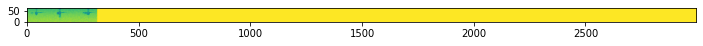

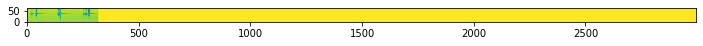

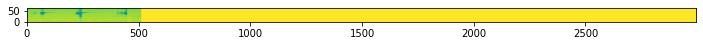

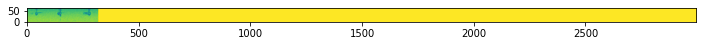

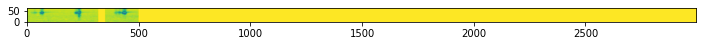

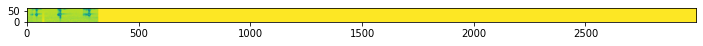

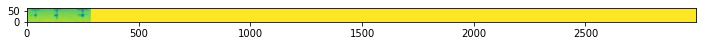

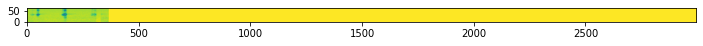

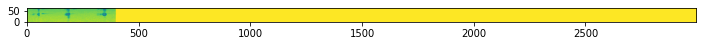

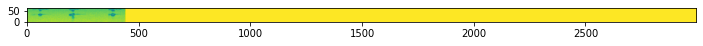

In [ ]:
# show
counter = 0
elementId = 364805
for x, y in tqdm(test_train.subset.unbatch(), total=test_train.size):
  if x['fname'] == tf.constant(elementId, dtype=tf.int64):
    wave = x[f'wav_{SAMPLE_RATE}_mono_input']

    spectrogram = tfio.audio.spectrogram(wave, nfft=512, window=512, stride=256)
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=64, fmin=125, fmax=SAMPLE_RATE//2)

    # Convert to db scale mel-spectrogram
    dbscale_log_mel_spectrogram = tfio.audio.dbscale(
        tf.math.log(mel_spectrogram+0.001), top_db=50)

    plt.figure(figsize=(12, 9))
    plt.imshow(dbscale_log_mel_spectrogram.numpy().T, origin='lower')
    counter += 1
    if counter == 10:
      break

Performance test

In [ ]:
bench_set = test_train
tfds.core.benchmark(bench_set, batch_size=32, num_iter=200)

## Train Models

Load data pipeline and create and train models.

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import logging
tf.get_logger().setLevel(logging.WARNING)

### CRNN

In [ ]:
ds = SplittedDatasets(
    Subset(tfrecords_dev_train, tfrecords_dev_train_size, tfrecords_dev_train_pos_size),
    Subset(tfrecords_dev_val, tfrecords_dev_val_size, tfrecords_dev_val_pos_size),
    Subset(tfrecords_eval, tfrecords_eval_size, tfrecords_eval_pos_size),
)

SAMPLE_RATE = 16000
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

train, val, eval = ds.prepare(sample_rate=SAMPLE_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, learningRate=LEARNING_RATE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: The FrequencyMask class has been deprecated and may be removed in a future version of audiomentations. You can use BandStopFilter instead. It has different defaults and different parameter randomization that is better aligned with human hearing.


In [ ]:
counter = 0
total = train.size//ds.batch_size
for xbatch, ybatch in tqdm(train.subset, total=total):
  print('x batch:', xbatch)
  print('y batch:', ybatch)
  break
  counter += 1
  if counter == total:
    break

print('Not augmented samples:', ds.notAugmentedErrors)

  0%|          | 0/333 [00:00<?, ?it/s]

x batch: {'fname': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([383600,  78968, 323127, 238638, 323132, 425842, 189433, 158502,
       238626, 254455,  78985, 158501, 158517,  76661,  78985, 158505,
        72523, 220822,  67656, 323127, 328823, 323132,  78985, 415798,
        93889, 323132, 323122, 156121, 156125, 196721, 364911, 156121])>, 'wav_16000_mono_input': <tf.Tensor: shape=(32, 441002), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.4680361e-10, -6.0114008e-10,  1.4557240e-09, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.7276253e-09,  4.0786539e-09, -1.0429578e-10, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  5.5792870e-10,  5.7153643e-11, ...,
         0.0000000e+00,  0

In [ ]:
tf.keras.backend.clear_session() # clear previous model (if cell is executed more than once)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.set_visible_devices(physical_devices[0:], 'GPU')
except:
    pass
model_crnn = crnn()
model_crnn.summary()
model_crnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ds.learning_rate),  
    loss={
        "class_output": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # "log_mel_spectrogram_output": None,
    },
    metrics={
        "class_output": [
            tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5, name='f1'),
            tfa.metrics.FBetaScore(num_classes=1, average='micro', beta=2.0, threshold=0.5, name='f2'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TruePositives(name='tp'),
        ],
        # "log_mel_spectrogram_output": [
        #   None,
        # ],
    },
    loss_weights={
        "class_output": 1.0, 
        # "log_mel_spectrogram_output": 0.0,
    }, 
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wav_16000_mono_input (Input  [(None, None)]           0         
 Layer)                                                          
                                                                 
 log_mel_spectrogram_transfo  ((None, None, 64),       0         
 rm (LogMelSpectrogramTransf   (None, None, 96, 64))             
 ormLayer)                                                       
                                                                 
 reshape (Reshape)           (None, None, 64, 1)       0         
                                                                 
 time_distributed_conv1d (Ti  (None, None, 33, 64)     2112      
 meDistributed)                                                  
                                                             

In [ ]:
modelName = 'crnn'
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=5, mode='max', restore_best_weights=True)
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_BASEPATH, modelName), save_best_only=True, monitor='val_f1', mode='max', verbose=0)
callbacks = [mcp_save]

model_history = model_crnn.fit(train.subset, batch_size=ds.batch_size, epochs=ds.epochs, steps_per_epoch=train.size//ds.batch_size,
               validation_data=val.subset, validation_freq=1, validation_batch_size=None, validation_steps=val.size//ds.batch_size,
               callbacks=callbacks)

history_json = f'{modelName}-history.json'
filepath_json = os.path.join(MODELS_BASEPATH, history_json)
with tf.io.gfile.GFile(filepath_json, "w+") as f:
  json.dump(model_history.history, f)

# model_crnn.save(os.path.join(MODELS_BASEPATH, modelName)) only needed, if ModelCheckpoint is not used

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


333/333 [==============================] - 282s 740ms/step - loss: 0.3484 - f1: 0.8692 - f2: 0.8901 - precision: 0.8366 - recall: 0.9046 - fn: 511.0000 - fp: 946.0000 - tp: 4843.0000 - val_loss: 0.0750 - val_f1: 0.9573 - val_f2: 0.9391 - val_precision: 0.9892 - val_recall: 0.9274 - val_fn: 43.0000 - val_fp: 6.0000 - val_tp: 549.0000
Epoch 2/20
333/333 [==============================] - 221s 664ms/step - loss: 0.1259 - f1: 0.9517 - f2: 0.9396 - precision: 0.9725 - recall: 0.9317 - fn: 366.0000 - fp: 141.0000 - tp: 4993.0000 - val_loss: 0.1718 - val_f1: 0.9140 - val_f2: 0.8781 - val_precision: 0.9808 - val_recall: 0.8557 - val_fn: 86.0000 - val_fp: 10.0000 - val_tp: 510.0000
Epoch 3/20
333/333 [==============================] - 222s 667ms/step - loss: 0.2020 - f1: 0.9109 - f2: 0.9063 - precision: 0.9187 - recall: 0.9032 - fn: 518.0000 - fp: 428.0000 - tp: 4836.0000 - val_loss: 0.1358 - val_f1: 0.9346 - val_f2: 0.9303 - val_precision: 0.9418 - val_recall: 0.9275 - val_fn: 43.0000 - val_fp

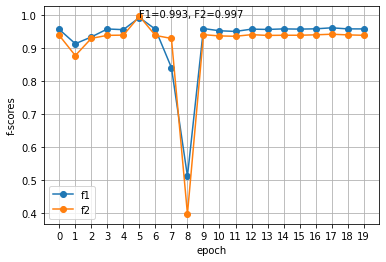

In [ ]:
metrics = ['f1', 'f2']
fig = plt.figure()
ax = fig.add_subplot(111)
for metric in metrics:
  plt.plot(model_history.history[f'val_{metric}'], marker='o')
xticks = [i for i in range(len(y))]

y = model_history.history[f'val_f1']
maxY = -1
maxY_index = -1
for i, e in enumerate(y):
  if e > maxY:
    maxY = e
    maxY_index = i
maxF1 = maxY
maxF2 = model_history.history[f'val_f2'][maxY_index]
xmax = xticks[maxY_index]

ax.annotate(f'F1={maxF1:.3f}, F2={maxF2:.3f}', xy=(xmax, maxY))

ax.set_ylabel('f-scores')
ax.set_xlabel('epoch')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.grid(axis='both')
ax.legend(metrics)
fig.show()

### YAMNet Base

In [ ]:
model_yn_base = yamnet_base()
model_yn_base.summary()
model_yn_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ds.learning_rate), 
    loss={
        "class_output": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # "log_mel_spectrogram_output": None,
    },
    metrics={
        "class_output": [
            tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5, name='f1'),
            tfa.metrics.FBetaScore(num_classes=1, average='micro', beta=2.0, threshold=0.5, name='f2'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TruePositives(name='tp'),
        ],
        # "log_mel_spectrogram_output": [
        #   None,
        # ],
    },
    loss_weights={
        "class_output": 1.0, 
        # "log_mel_spectrogram_output": 0.0,
    }, 
)

Model: "yamnet_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wav_16000_mono_input (Input  [(None, None)]           0         
 Layer)                                                          
                                                                 
 yamnet_wrapper (YAMNetWrapp  {'scores': (None, None,   0        
 er)                         521),                               
                              'spectrogram': (None, N            
                             one, 64)}                           
                                                                 
 tf.__operators__.getitem (S  (None, None)             0         
 licingOpLambda)                                                 
                                                                 
 scores (Layer)              (None, None)              0         
                                                       

In [ ]:
modelName = 'yamnet_base'

model_yn_base.save(os.path.join(MODELS_BASEPATH, modelName))

INFO:tensorflow:Assets written to: gs://thesis-bicycle-bell-sed-bucket-na/models/yamnet_base/assets


INFO:tensorflow:Assets written to: gs://thesis-bicycle-bell-sed-bucket-na/models/yamnet_base/assets


### YAMNET Extended

In [ ]:
ds = SplittedDatasets(
    Subset(tfrecords_dev_train, tfrecords_dev_train_size, tfrecords_dev_train_pos_size),
    Subset(tfrecords_dev_val, tfrecords_dev_val_size, tfrecords_dev_val_pos_size),
    Subset(tfrecords_eval, tfrecords_eval_size, tfrecords_eval_pos_size),
)

SAMPLE_RATE = 16000
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 0.001

train, val, eval = ds.prepare(sample_rate=SAMPLE_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, learningRate=LEARNING_RATE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: The FrequencyMask class has been deprecated and may be removed in a future version of audiomentations. You can use BandStopFilter instead. It has different defaults and different parameter randomization that is better aligned with human hearing.


In [ ]:
model_yn_extended = yamnet_lstm_fc()
model_yn_extended.summary()
model_yn_extended.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ds.learning_rate), 
    loss={
        "class_output": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # "log_mel_spectrogram_output": None,
    },
    metrics={
        "class_output": [
            tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5, name='f1'),
            tfa.metrics.FBetaScore(num_classes=1, average='micro', beta=2.0, threshold=0.5, name='f2'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TruePositives(name='tp'),
        ],
        # "log_mel_spectrogram_output": [
        #   None,
        # ],
    },
    loss_weights={
        "class_output": 1.0, 
        # "log_mel_spectrogram_output": 0.0,
    }, 
)

Model: "yamnet_lstm_fc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wav_16000_mono_input (Input  [(None, None)]           0         
 Layer)                                                          
                                                                 
 yamnet_wrapper (YAMNetWrapp  {'embeddings': (None, No  0        
 er)                         ne, 1024),                          
                              'spectrogram': (None, N            
                             one, 64)}                           
                                                                 
 yamnet_embeddings (Layer)   (None, None, 1024)        0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          66624     
                                                                 
 time_distributed_dense_1 (T  (None, None, 16)      

In [ ]:
modelName = 'yamnet_extended'
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=5, mode='max', restore_best_weights=True)
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_BASEPATH, modelName), save_best_only=True, monitor='val_f1', mode='max', verbose=0)
callbacks = [mcp_save]

model_history = model_yn_extended.fit(train.subset, batch_size=ds.batch_size, epochs=ds.epochs, steps_per_epoch=train.size//ds.batch_size,
               validation_data=val.subset, validation_freq=1, validation_batch_size=None, validation_steps=val.size//ds.batch_size,
               callbacks=callbacks)

history_json = f'{modelName}-history.json'
filepath_json = os.path.join(MODELS_BASEPATH, history_json)
with tf.io.gfile.GFile(filepath_json, "w+") as f:
  json.dump(model_history.history, f)

# model_yn_extended.save(os.path.join(MODELS_BASEPATH, modelName)) only needed, if ModelCheckpoint is not used

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2671/2671 [==============================] - 325s 105ms/step - loss: 0.0456 - f1: 0.9876 - f2: 0.9825 - precision: 0.9962 - recall: 0.9791 - fn: 112.0000 - fp: 20.0000 - tp: 5257.0000 - val_loss: 0.4044 - val_f1: 0.9611 - val_f2: 0.9411 - val_precision: 0.9964 - val_recall: 0.9282 - val_fn: 43.0000 - val_fp: 2.0000 - val_tp: 556.0000
Epoch 2/20
2671/2671 [==============================] - 267s 100ms/step - loss: 0.0093 - f1: 0.9993 - f2: 0.9994 - precision: 0.9991 - recall: 0.9994 - fn: 3.0000 - fp: 5.0000 - tp: 5366.0000 - val_loss: 0.4662 - val_f1: 0.9613 - val_f2: 0.9414 - val_precision: 0.9964 - val_recall: 0.9286 - val_fn: 43.0000 - val_fp: 2.0000 - val_tp: 559.0000
Epoch 3/20
2671/2671 [==============================] - 253s 95ms/step - loss: 0.0077 - f1: 0.9990 - f2: 0.9988 - precision: 0.9993 - recall: 0.9987 - fn: 7.0000 - fp: 4.0000 - tp: 5362.0000 - val_loss: 0.3353 - val_f1: 0.9588 - val_f2: 0.9404 - val_precision: 0.9911 - val_recall: 0.9286 - val_fn: 43.0000 - val_fp: 5.0

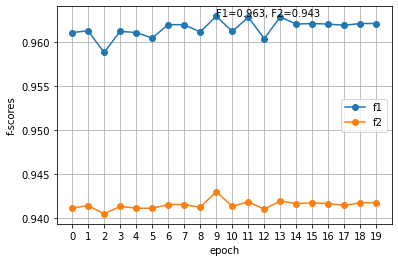

In [ ]:
metrics = ['f1', 'f2']
fig = plt.figure()
ax = fig.add_subplot(111)
for metric in metrics:
  plt.plot(model_history.history[f'val_{metric}'], marker='o')
xticks = [i for i in range(len(y))]

y = model_history.history[f'val_f1']
maxY = -1
maxY_index = -1
for i, e in enumerate(y):
  if e > maxY:
    maxY = e
    maxY_index = i
maxF1 = maxY
maxF2 = model_history.history[f'val_f2'][maxY_index]
xmax = xticks[maxY_index]

ax.annotate(f'F1={maxF1:.3f}, F2={maxF2:.3f}', xy=(xmax, maxY))

ax.set_ylabel('f-scores')
ax.set_xlabel('epoch')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.grid(axis='both')
ax.legend(metrics)
fig.show()

## Evaluate Models

Run models on the hold-out evaluation dataset. The `imbalanced_eval` set does not includes any oversampled or augmentated samples.

In [ ]:
ds = SplittedDatasets(
    Subset(tfrecords_dev_train, tfrecords_dev_train_size, tfrecords_dev_train_pos_size),
    Subset(tfrecords_dev_val, tfrecords_dev_val_size, tfrecords_dev_val_pos_size),
    Subset(tfrecords_eval, tfrecords_eval_size, tfrecords_eval_pos_size),
)

SAMPLE_RATE = 16000
BATCH_SIZE = 32 # 1
EPOCHS = 1
LEARNING_RATE = 0.001

train, val, eval = ds.prepare(sample_rate=SAMPLE_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, learningRate=LEARNING_RATE)

imbalanced_eval = ds.prepared_imbalanced_evalSubset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: The FrequencyMask class has been deprecated and may be removed in a future version of audiomentations. You can use BandStopFilter instead. It has different defaults and different parameter randomization that is better aligned with human hearing.


In [ ]:
def printFN_filenames(model, ds: SplittedDatasets, subset: Subset):
  for xbatch, ybatch in tqdm(subset.subset, total=subset.size//ds.batch_size):
    y_pred = model.predict_on_batch(xbatch['wav_16000_mono_input'])
    for x_fname, x_audio, y, y_p in zip(xbatch['fname'], xbatch['wav_16000_mono_input'], ybatch['class_output'], y_pred):
      if y == 1:
        if y_p < 0.5:
          print(x_fname, y_p)

### CRNN

In [ ]:
modelName = 'crnn'
model_crnn = tf.keras.models.load_model(os.path.join(MODELS_BASEPATH, modelName))

Prove that padding in batches doesn't have a significant impact on the predictions:

Evaluate with `BATCH_SIZE=1` ones and compare with different value for `BATCH_SIZE`.

In [ ]:
# BATCH_SIZE == 1
eval_dict_crnn = model_crnn.evaluate(eval.subset, steps=eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4768/4768 [==============================] - 732s 144ms/step - loss: 0.3212 - f1: 0.9266 - f2: 0.8949 - precision: 0.9846 - recall: 0.8750 - fn: 301.0000 - fp: 33.0000 - tp: 2107.0000


In [ ]:
# BATCH_SIZE == 32
eval_dict_crnn = model_crnn.evaluate(eval.subset, steps=eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


149/149 [==============================] - 70s 220ms/step - loss: 0.3146 - f1: 0.9344 - f2: 0.9090 - precision: 0.9799 - recall: 0.8929 - fn: 258.0000 - fp: 44.0000 - tp: 2150.0000


In [ ]:
# BATCH_SIZE == 1
imbalanced_eval_dict_crnn = model_crnn.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

2416/2416 [==============================] - 430s 158ms/step - loss: 0.0478 - f1: 0.7101 - f2: 0.8007 - precision: 0.5976 - recall: 0.8750 - fn: 7.0000 - fp: 33.0000 - tp: 49.0000


In [ ]:
# BATCH_SIZE == 32
imbalanced_eval_dict_crnn = model_crnn.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

75/75 [==============================] - 57s 195ms/step - loss: 0.0554 - f1: 0.6711 - f2: 0.7962 - precision: 0.5319 - recall: 0.9091 - fn: 5.0000 - fp: 44.0000 - tp: 50.0000


In [ ]:
printFN_filenames(model_crnn, ds, imbalanced_eval)

  0%|          | 0/75 [00:00<?, ?it/s]

tf.Tensor(210262, shape=(), dtype=int64) 0.0014817094
tf.Tensor(275353, shape=(), dtype=int64) 0.0013188674
tf.Tensor(156064, shape=(), dtype=int64) 0.0025302458
tf.Tensor(191901, shape=(), dtype=int64) 0.008026091
tf.Tensor(101746, shape=(), dtype=int64) 0.0018915838
tf.Tensor(90649, shape=(), dtype=int64) 0.45055547


### YAMNet Base

In [ ]:
modelName = 'yamnet_base'
model_yn_base = tf.keras.models.load_model(os.path.join(MODELS_BASEPATH, modelName))

In [ ]:
eval_dict_yn_base = model_yn_base.evaluate(eval.subset, steps=eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


149/149 [==============================] - 65s 192ms/step - loss: 1.0461 - f1: 0.6340 - f2: 0.5200 - precision: 0.9991 - recall: 0.4643 - fn: 1290.0000 - fp: 1.0000 - tp: 1118.0000


In [ ]:
# BATCH_SIZE == 1
imbalanced_eval_dict_yn_base = model_yn_base.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2416/2416 [==============================] - 355s 127ms/step - loss: 0.0539 - f1: 0.6265 - f2: 0.5179 - precision: 0.9630 - recall: 0.4643 - fn: 30.0000 - fp: 1.0000 - tp: 26.0000


In [ ]:
# BATCH_SIZE == 32
imbalanced_eval_dict_yn_base = model_yn_base.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

75/75 [==============================] - 54s 163ms/step - loss: 0.0509 - f1: 0.6265 - f2: 0.5179 - precision: 0.9630 - recall: 0.4643 - fn: 30.0000 - fp: 1.0000 - tp: 26.0000


### YAMNet Extended

In [ ]:
modelName = 'yamnet_extended'
model_yn_extended = tf.keras.models.load_model(os.path.join(MODELS_BASEPATH, modelName))

In [ ]:
eval_dict_yn_extended = model_yn_extended.evaluate(eval.subset, steps=eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


149/149 [==============================] - 76s 215ms/step - loss: 0.9084 - f1: 0.9212 - f2: 0.8817 - precision: 0.9957 - recall: 0.8571 - fn: 344.0000 - fp: 9.0000 - tp: 2064.0000


In [ ]:
# BATCH_SIZE == 1
imbalanced_eval_dict_yn_extended = model_yn_extended.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['fname'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2416/2416 [==============================] - 371s 131ms/step - loss: 0.0862 - f1: 0.8421 - f2: 0.8511 - precision: 0.8276 - recall: 0.8571 - fn: 8.0000 - fp: 10.0000 - tp: 48.0000


In [ ]:
# BATCH_SIZE == 32
imbalanced_eval_dict_yn_extended = model_yn_extended.evaluate(imbalanced_eval.subset, steps=imbalanced_eval.size//ds.batch_size, return_dict=True)

75/75 [==============================] - 61s 163ms/step - loss: 0.0867 - f1: 0.8468 - f2: 0.8514 - precision: 0.8393 - recall: 0.8545 - fn: 8.0000 - fp: 9.0000 - tp: 47.0000


In [ ]:
printFN_filenames(model_yn_extended, ds, imbalanced_eval)

  0%|          | 0/75 [00:00<?, ?it/s]

tf.Tensor(152953, shape=(), dtype=int64) 1.3801369e-14
tf.Tensor(275353, shape=(), dtype=int64) 2.2438708e-35
tf.Tensor(153054, shape=(), dtype=int64) 9.1237425e-23
tf.Tensor(348325, shape=(), dtype=int64) 0.16123699
tf.Tensor(90649, shape=(), dtype=int64) 4.699661e-31
tf.Tensor(232963, shape=(), dtype=int64) 3.0436471e-30
tf.Tensor(378908, shape=(), dtype=int64) 8.135064e-13
tf.Tensor(101746, shape=(), dtype=int64) 0.032235734


## Create System Test Files

Should be run on CPU for using larger memory/RAM.

In [ ]:
ds = SplittedDatasets(
    Subset(tfrecords_dev_train, tfrecords_dev_train_size, tfrecords_dev_train_pos_size),
    Subset(tfrecords_dev_val, tfrecords_dev_val_size, tfrecords_dev_val_pos_size),
    Subset(tfrecords_eval, tfrecords_eval_size, tfrecords_eval_pos_size),
)

SAMPLE_RATE = 16000
BATCH_SIZE = 1
EPOCHS = 1
LEARNING_RATE = 0.001

train, val, eval = ds.prepare(sample_rate=SAMPLE_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, learningRate=LEARNING_RATE)

imbalanced_eval = ds.prepared_imbalanced_evalSubset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: The FrequencyMask class has been deprecated and may be removed in a future version of audiomentations. You can use BandStopFilter instead. It has different defaults and different parameter randomization that is better aligned with human hearing.


3 Test cases:
- balanced eval data with oversampling
- balanced eval data with undersampling
- imbalanced eval data

In [ ]:
def createTestFiles(testName, listOfSamples, sr):
  filepath_csv = os.path.join(SYSTEMTEST_BASEPATH, f'{testName}.csv')
  with tf.io.gfile.GFile(filepath_csv, "w") as f:
    writer = csv.writer(f, delimiter=',')
    timePassed = 0
    for sample in listOfSamples:
      startTime = timePassed
      endTime = startTime + sample['duration']
      row = [f'{startTime:.3f}', f'{endTime:.3f}', int(sample['fname']), bool(sample['y'])]
      writer.writerow(row)
      timePassed = endTime

  filepath_wav = os.path.join(SYSTEMTEST_BASEPATH, f'{testName}.wav')
  concatenatedAudioTensor = tf.concat([s['audio'] for s in listOfSamples], 0)
  tensorString = tf.audio.encode_wav(tf.expand_dims(concatenatedAudioTensor, -1), sr)
  tf.io.write_file(filepath_wav, tensorString)

def stdTestCase(testName: str, ds, subsetS: Subset, maxWaveBytes: int=4e+9):
  sr = int(ds.sample_rate)
  atMax = False
  sizeOfTensor = 0
  listOfSamples = []
  for xbatch, ybatch in tqdm(subsetS.subset, total=subsetS.size//ds.batch_size):
    for x_fname, x_audio, y in zip(xbatch['fname'], xbatch[f'wav_{sr}_mono_input'], ybatch['class_output']):
      sampleDict = {}
      sampleDict['fname'] = x_fname
      sampleDict['audio'] = x_audio
      sampleDict['y'] = y
      sampleDict['duration'] = x_audio.shape[0] / sr
      bytesOfSample = x_audio.shape[0] * 16 / 8 # number of floats * 16 bit to byte (/8)
      if sizeOfTensor+bytesOfSample >= maxWaveBytes:
        atMax = True
        break
      else:
        listOfSamples.append(sampleDict)
        sizeOfTensor += bytesOfSample
    if atMax:
      break
  print(f'Prepared {len(listOfSamples)} with {int(sizeOfTensor)} bytes for concatenation to the wave file.')
  createTestFiles(testName, listOfSamples, sr)

In [ ]:
# 1. test case
testName = 'systemTest_subEval_balanced_withOversampling'
stdTestCase(testName, ds, eval)

# 2. test case
testName = 'systemTest_subEval_balanced_withUndersampling'
listOfSamples = []
sr = ds.sample_rate
num_negSamples = 0
num_posSamples = 0
for xbatch, ybatch in tqdm(imbalanced_eval.subset, total=imbalanced_eval.size//ds.batch_size):
  for x_fname, x_audio, y in zip(xbatch['fname'], xbatch[f'wav_{sr}_mono_input'], ybatch['class_output']):
    if y == 1 or num_negSamples < num_posSamples:
      sampleDict = {}
      sampleDict['fname'] = x_fname
      sampleDict['audio'] = x_audio
      sampleDict['y'] = y
      sampleDict['duration'] = x_audio.shape[0] / sr
      listOfSamples.append(sampleDict)
      if y == 1:
        num_posSamples += 1
      else:
        num_negSamples += 1
print('Positive Samples:', num_posSamples)
print('Negative Samples:', num_negSamples)
createTestFiles(testName, listOfSamples, sr)

# 3. test case
testName = 'systemTest_subEval_imbalanced'
stdTestCase(testName, ds, imbalanced_eval)

  0%|          | 0/4768 [00:00<?, ?it/s]

Prepared 4768 with 1546150986 bytes for concatenation to the wave file.


  0%|          | 0/2416 [00:00<?, ?it/s]

Positive Samples: 56
Negative Samples: 56


  0%|          | 0/2416 [00:00<?, ?it/s]

Prepared 2416 with 883380822 bytes for concatenation to the wave file.


## Create GCS Bucket Backup as Zip

In [ ]:
if AS_ADMIN:
  !mkdir ./thesis-bicycle-bell-sed-bucket
  !gsutil -m cp -r "gs://thesis-bicycle-bell-sed-bucket-na/csv-datasets" "gs://thesis-bicycle-bell-sed-bucket-na/downloaded" "gs://thesis-bicycle-bell-sed-bucket-na/models" "gs://thesis-bicycle-bell-sed-bucket-na/system-tests" "gs://thesis-bicycle-bell-sed-bucket-na/tfrecords" "gs://thesis-bicycle-bell-sed-bucket-na/wave-files" ./thesis-bicycle-bell-sed-bucket
  !zip -r ./thesis-bicycle-bell-sed-bucket.zip ./thesis-bicycle-bell-sed-bucket

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327681.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327683.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327688.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327671.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327756.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327835.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327843.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327900.wav...
Copying gs://thesis-bicycle-bell-sed-bucket-na/wave-files/originals/FSD50K.eval_audio/327906.wav...
Copying gs://thesis-bicycle-bell-

In [ ]:
!zip -r ./thesis-bicycle-bell-sed-bucket.zip ./thesis-bicycle-bell-sed-bucket

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/92066.wav (deflated 7%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/166969.wav (deflated 79%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/268560.wav (deflated 32%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/194782.wav (deflated 5%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/248843.wav (deflated 28%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/243574.wav (deflated 18%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/158777.wav (deflated 48%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/80954.wav (deflated 26%)
  adding: thesis-bicycle-bell-sed-bucket/wave-files/originals/FSD50K.dev_audio/156847.wav (deflat

In [ ]:
!cp /content/thesis-bicycle-bell-sed-bucket.zip /content/drive/MyDrive/Studium/IFI/Bachelorarbeit/Abgabe